In [1]:
import os
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

mats = []
labels = []
files = []
for dirname, _, filenames in os.walk('/kaggle/input/scz-nkd-dataset/img'):
    for filename in filenames:
        if filename[0:3] == 'nkd':
            labels.append(0)
        else:
            labels.append(1)
        file = os.path.join(dirname, filename)
        files.append(file)
        img = Image.open(file).convert('LA')
        mat = np.array(img)
        mats.append(mat)

In [2]:
x = np.array(mats)
y = np.array(labels)

In [3]:
import tensorflow as tf
schizNet = tf.keras.models.load_model('/kaggle/input/schiznetmodel/schizNet.h5')
schizNet.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_207 (Conv2D)          (None, 512, 512, 16)      304       
_________________________________________________________________
conv2d_208 (Conv2D)          (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d_95 (MaxPooling (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_209 (Conv2D)          (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_210 (Conv2D)          (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_211 (Conv2D)          (None, 128, 128, 64)    

In [4]:
loss, acc = schizNet.evaluate(x, y)
print('Loss: ', loss)
print('Accuracy: ', acc)

4/4 [==============================] - 19s 5s/step - loss: 0.2884 - accuracy: 0.9062
Loss:  0.2884397804737091
Accuracy:  0.90625


In [5]:
def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [6]:
def make_gradcam_heatmap(img_array, modelOne, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        inputs=modelOne.input, outputs=[modelOne.get_layer(last_conv_layer_name).output, modelOne.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = preds[0]
        class_channel = preds[:, 0]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    return pred_index, heatmap.numpy()

In [7]:
results = {"True Positive": [], "False Positive": [], "True Negative": [], "False Negative": []}
for mat, label in zip(x, labels):
    prediction, heatmap = make_gradcam_heatmap(np.expand_dims(mat, axis=0), schizNet, 'conv2d_219')
    pred = prediction.numpy()
    if label == 0 and np.round(pred) == np.array(0):
        results["True Negative"].append(heatmap)
    elif label == 1 and np.round(pred) == np.array(1):
        results["True Positive"].append(heatmap)
    elif label == 0 and np.round(pred) == np.array(1):
        results["False Positive"].append(heatmap)
    else:
        results["False Negative"].append(heatmap)

In [8]:
aal3 = open('/kaggle/input/aal3-1mm/AAL3_1mm.txt')
parcellations = [str(s) for s in aal3.read().strip().split("\n")]
print(parcellations)

['1 Precentral_L', '2 Precentral_R', '3 Frontal_Sup_2_L', '4 Frontal_Sup_2_R', '5 Frontal_Mid_2_L', '6 Frontal_Mid_2_R', '7 Frontal_Inf_Oper_L', '8 Frontal_Inf_Oper_R', '9 Frontal_Inf_Tri_L', '10 Frontal_Inf_Tri_R', '11 Frontal_Inf_Orb_2_L', '12 Frontal_Inf_Orb_2_R', '13 Rolandic_Oper_L', '14 Rolandic_Oper_R', '15 Supp_Motor_Area_L', '16 Supp_Motor_Area_R', '17 Olfactory_L', '18 Olfactory_R', '19 Frontal_Sup_Medial_L', '20 Frontal_Sup_Medial_R', '21 Frontal_Med_Orb_L', '22 Frontal_Med_Orb_R', '23 Rectus_L', '24 Rectus_R', '25 OFCmed_L', '26 OFCmed_R', '27 OFCant_L', '28 OFCant_R', '29 OFCpost_L', '30 OFCpost_R', '31 OFClat_L', '32 OFClat_R', '33 Insula_L', '34 Insula_R', '35 Cingulate_Mid_L', '36 Cingulate_Mid_R', '37 Cingulate_Post_L', '38 Cingulate_Post_R', '39 Hippocampus_L', '40 Hippocampus_R', '41 ParaHippocampal_L', '42 ParaHippocampal_R', '43 Amygdala_L', '44 Amygdala_R', '45 Calcarine_L', '46 Calcarine_R', '47 Cuneus_L', '48 Cuneus_R', '49 Lingual_L', '50 Lingual_R', '51 Occipi

In [9]:
nkd = np.array(results["True Negative"])
nkd_heatmap = np.mean(nkd, axis=0)
nkd_image = Image.fromarray(nkd_heatmap)
nkd_image = nkd_image.resize((166, 166), Image.ANTIALIAS)

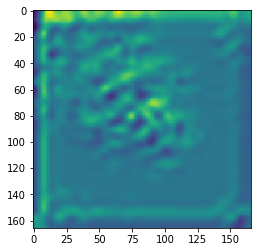

In [10]:
nkd_heatmap = np.array(nkd_image)
nkd_heatmap = nkd_heatmap / nkd_heatmap.max()
plt.imshow(nkd_heatmap, interpolation = 'nearest')

In [11]:
i,j = np.unravel_index(nkd_heatmap.argmax(), nkd_heatmap.shape)
print("NKD Area of Interest: the connection between " + parcellations[i] + " and " + parcellations[j])
nkd_row = np.argmax(nkd_heatmap, axis = 0)
nkd_r_mode = stats.mode(nkd_row).mode[0]
nkd_column = np.argmax(nkd_heatmap, axis = 1)
nkd_c_mode = stats.mode(nkd_column).mode[0]
nkd_arr = np.append(nkd_row, nkd_column)
nkd_mode = stats.mode(nkd_arr).mode[0]
print("NKD Row Region of Interest: " + parcellations[nkd_r_mode])
print("NKD Column Region of Interest: " + parcellations[nkd_c_mode])
print("NKD Overall Region of Interest: " + parcellations[nkd_mode])

NKD Area of Interest: the connection between 1 Precentral_L and 13 Rolandic_Oper_L
NKD Row Region of Interest: 1 Precentral_L
NKD Column Region of Interest: 9 Frontal_Inf_Tri_L
NKD Overall Region of Interest: 1 Precentral_L


In [12]:
scz = np.array(results["True Positive"])
scz_heatmap = np.mean(scz, axis=0)
scz_image = Image.fromarray(scz_heatmap)
scz_image = scz_image.resize((166, 166), Image.ANTIALIAS)

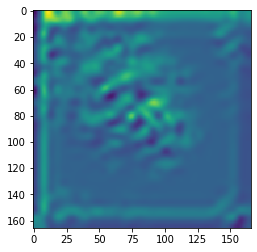

In [13]:
scz_heatmap = np.array(scz_image)
scz_heatmap = scz_heatmap / scz_heatmap.max()
plt.imshow(scz_heatmap, interpolation = 'nearest')

In [14]:
i,j = np.unravel_index(scz_heatmap.argmax(), scz_heatmap.shape)
print("SCZ Area of Interest: the connection between " + parcellations[i] + " and " + parcellations[j])
scz_row = np.argmax(scz_heatmap, axis = 0)
scz_r_mode = stats.mode(scz_row).mode[0]
scz_column = np.argmax(scz_heatmap, axis = 1)
scz_c_mode = stats.mode(scz_column).mode[0]
scz_arr = np.append(scz_row, scz_column)
scz_mode = stats.mode(scz_arr).mode[0]
print("SCZ Row Region of Interest: " + parcellations[scz_r_mode])
print("SCZ Column Region of Interest: " + parcellations[scz_c_mode])
print("SCZ Overall Region of Interest: " + parcellations[scz_mode])

SCZ Area of Interest: the connection between 1 Precentral_L and 12 Frontal_Inf_Orb_2_R
SCZ Row Region of Interest: 1 Precentral_L
SCZ Column Region of Interest: 9 Frontal_Inf_Tri_L
SCZ Overall Region of Interest: 1 Precentral_L


In [15]:
print("Number of true negatives: ", len(results['True Negative']))
print("Number of false negatives: ", len(results['False Negative']))
print("Number of false positives: ", len(results['False Positive']))
print("Number of true positives: ", len(results['True Positive']))

Number of true negatives:  70
Number of false negatives:  10
Number of false positives:  2
Number of true positives:  46
